### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.layers import Input, Dense
from training.datasets import load_dataset
from models.gpu.layers import Normalizer
from models.gpu.metrics import MaxAbsoluteError
from training.utils import CustomTensorboard
from models.analytical import MultiOccupationMultiIsotope
import numpy as np
from tqdm.auto import tqdm


# Multi-Occupation, Multi Isotope, fixed matrix, normalized

In [3]:
info, (train_x,train_y),(val_x,val_y) = load_dataset("Multi-Occupation, Multi Isotope, fixed matrix, normalized")

In [11]:
model = keras.Sequential(
    [
        Input(shape= (info["input_channels"],)),
        Dense(256,activation="relu"),
        Dense(256,activation="relu"),
        Dense(256,activation="relu"),
        Dense(256,activation="relu"),
        Dense(info["output_channels"], activation="leaky_relu"),
        Normalizer(norm_loss_weight=0.1)
    ]
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)               │      3,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_13 (Dense)                │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_14 (Dense)                │ (None, 12)                │      3,084 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ normalizer_3 (Normalizer)       │ (None, 12)                │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 204,044 (797.05 KB)

 Trainable params: 204,044 (797.05 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(
        # learning_rate=keras.optimizers.schedules.CosineDecayRestarts(
        #     initial_learning_rate=1e-3,
        #     first_decay_steps=5000,
        #     t_mul = 1.5,
        #     m_mul = 0.3,
        #     alpha = 1e-4,
        #     )
        learning_rate= 3e-3
    ),
    loss="mae",
    metrics=[
        MaxAbsoluteError(),
        # MeanAbsoluteMassLoss(),
        "mae",
    ],
)

In [ ]:
model.fit(
    train_x,
    train_y,
    validation_data = (val_x, val_y),
    batch_size=2**13,
    epochs=100,
    shuffle = True,
    callbacks = [
        CustomTensorboard("logs/momi_fixed_normalized", name = "small manual"),
        keras.callbacks.ReduceLROnPlateau(
            factor = 0.5,
            min_lr=1e-4,
            patience=10
        )
        # keras.callbacks.LearningRateScheduler(manual_scheduler),
    ],
)

In [4]:
model = keras.models.load_model("trained_models/MOMI_fixed_normalized.keras")

In [5]:
predictions = model.predict(val_x, batch_size=2**12)
predictions.shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


(49500, 12)

In [6]:
indices = np.argsort(np.max(np.abs(predictions - val_y),axis= 1))
worst = indices[-100:]

array([39133,  3383,  5964, 39624, 44092,  8637, 17437,  4177,  4356,
       39636, 33974, 49124, 36164,  4379, 13284,  9731, 24588, 41304,
        4386, 34380, 37354, 34388,  4383, 36162, 30701,  9722, 17438,
        4390, 31307, 32008, 30702, 34381, 39625, 36163, 34357, 32013,
       34783, 21352, 33970, 24589,  9725, 39635, 31303, 17439, 34374,
       34373,  4396, 36154,  4384,  4382, 33971, 39134, 39628, 39626,
       36149, 13282,  8636, 32014,  9724, 32010, 42196,  9723, 39137,
       39627, 33877, 33876, 13283,  4385,  4395,  9738, 21353, 42197,
       36150, 34356,  4381, 32016, 32015, 32009, 36153,  9740, 36151,
        4380,  4394, 36152, 21359, 21354, 34355,  9739, 31304,  4392,
       21358, 21357, 31306,  4391, 31305,  4393, 21355, 34354, 21356,
       34353], dtype=int64)

In [9]:
momi = MultiOccupationMultiIsotope(fixed=True)
worst_iv = None
worst_max_ae = None

In [20]:
for i in tqdm(range(200)):
    x,y = momi.training_data(include_params=False, n_eval = 100, log_t_eval=True)
    y*= momi.correction_factors()
    iv = x[0,1:]
    predictions = model.predict(x,verbose = 0)
    max_ae = np.max(np.abs(predictions - y))
    if worst_max_ae is None or max_ae > worst_max_ae:
        print(f"New worst AE: {max_ae}")
        worst_max_ae = max_ae
        worst_iv = iv

  0%|          | 0/200 [00:00<?, ?it/s]

New worst AE: 0.1063387624005932


initial values: [0.0241695  0.04515299 0.07201259 0.058158   0.00393623 0.00574905
 0.02870307 0.00095882 0.06056631 0.07357488 0.05853341 0.07324586]
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


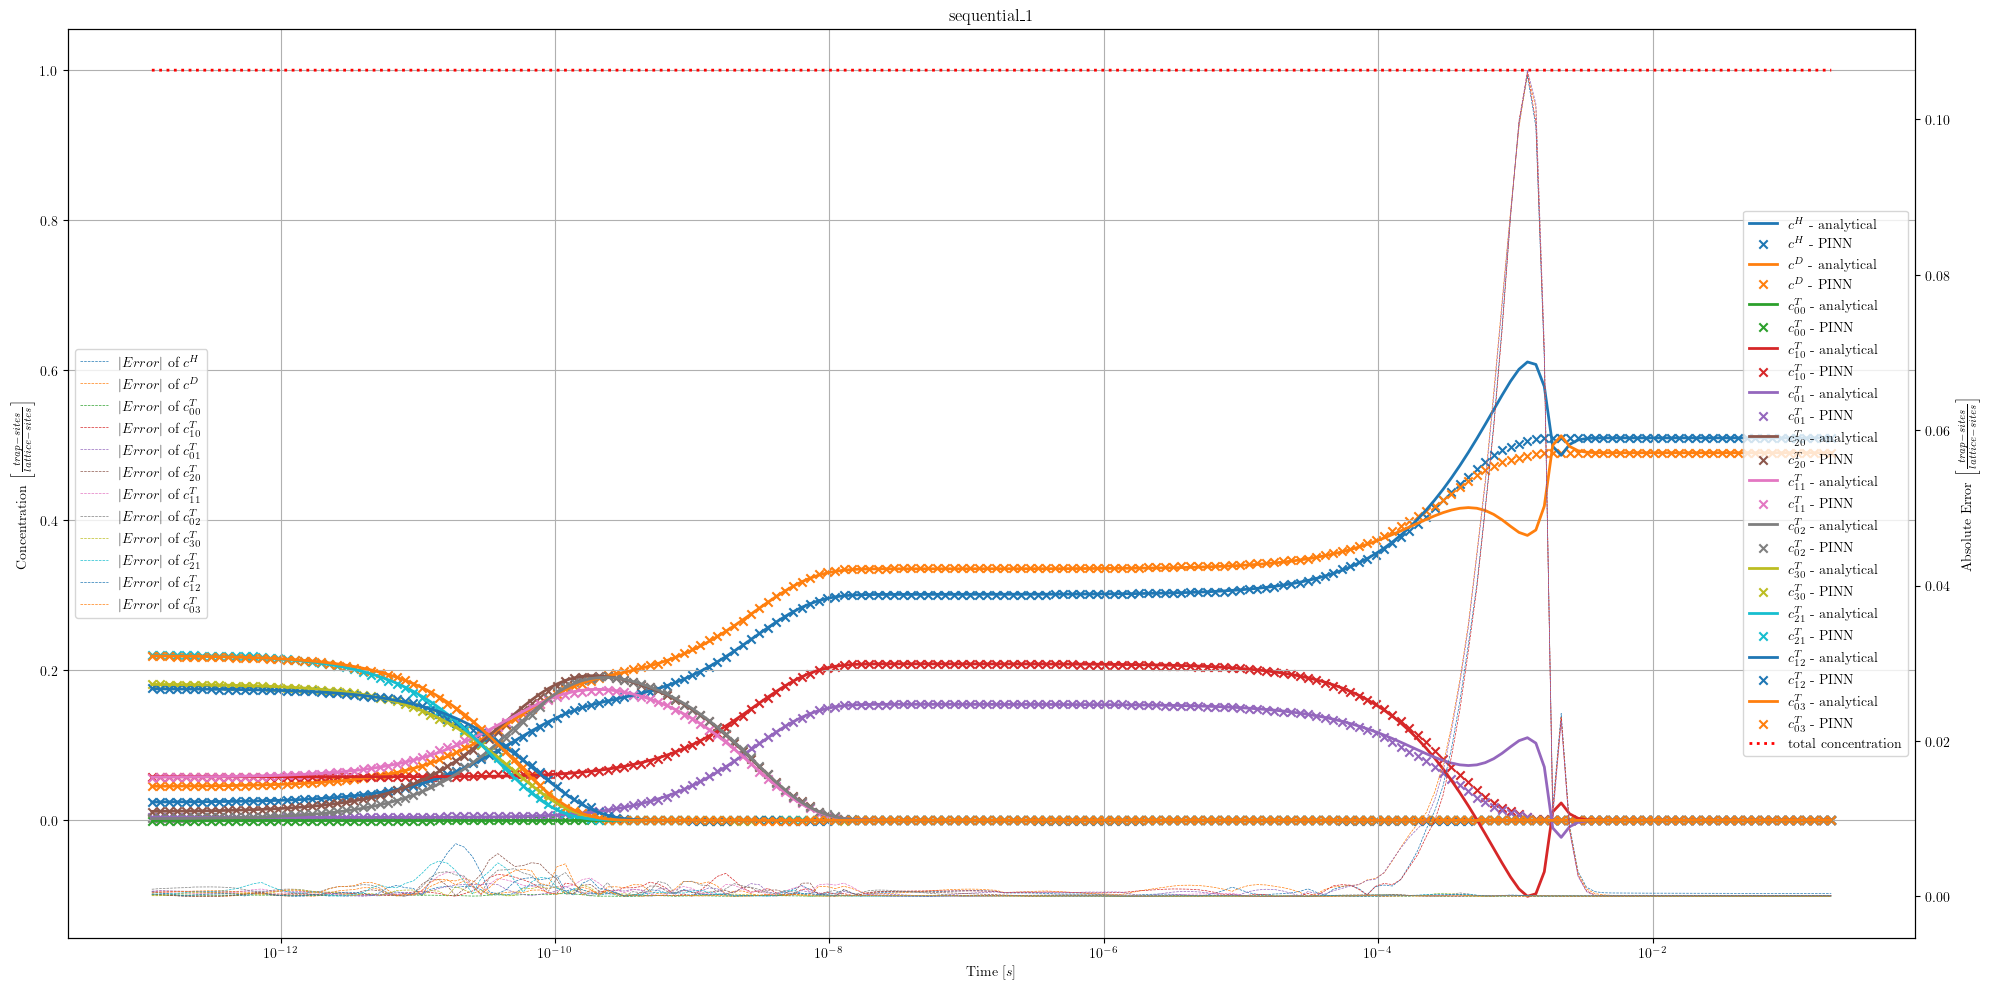

In [33]:
initial_values = worst_iv#val_x[worst[-1],1:]

print(f"initial values: {initial_values}")
momi.evaluate(model, pre_normalized=True, initial_values=initial_values, n_eval=200, log_t_eval=True)